<a href="https://colab.research.google.com/github/itsyoru/tumor_classification/blob/main/TumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fawady2j","key":"ac60a0a8669864afbe08f78db845443f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-tumor-mri-dataset.zip
replace /content/brain_tumor_dataset/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

In [5]:
train_dir = "/content/brain_tumor_dataset/Training"
test_dir = "/content/brain_tumor_dataset/Testing"

import os
trainClasses = os.listdir(train_dir)
testClasses = os.listdir(test_dir)
print("Training Classes:", trainClasses)
print("Testing Classes:", testClasses)

Training Classes: ['glioma', 'notumor', 'pituitary', 'meningioma']
Testing Classes: ['glioma', 'notumor', 'pituitary', 'meningioma']


In [6]:
IMG_SIZE = (224, 224)

def resize_images_in_directory(directory, size):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path)

                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    img = img.resize(size)
                    img.save(img_path)
                except UnidentifiedImageError:
                    print(f"Skipping invalid image: {img_path}")
                    os.remove(img_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")


resize_images_in_directory(train_dir, IMG_SIZE)
resize_images_in_directory(test_dir, IMG_SIZE)

print("Images resized successfully!")


Images resized successfully!


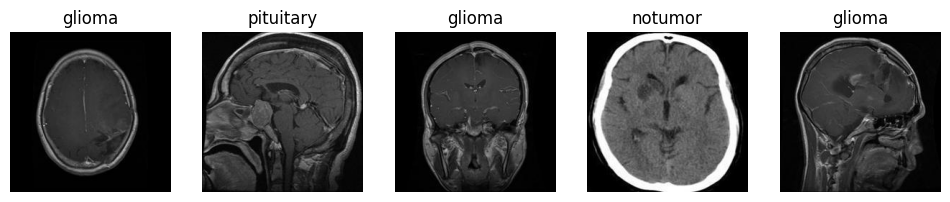

In [7]:
num_images = 5
plt.figure(figsize=(12, 6))

for i in range(num_images):
    random_class = random.choice(testClasses)
    class_path = os.path.join(train_dir, random_class)

    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)

    img = Image.open(image_path)

    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.title(random_class)
    plt.axis("off")

plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")


Training dataset size: 5712
Testing dataset size: 1311


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.flatten_size = self._get_flatten_size()

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 4)

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            return x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BrainTumorCNN()
print(model)


BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training epoch 0...
Batch 1/179, Loss: 1.3879
Batch 11/179, Loss: 1.3836
Batch 21/179, Loss: 1.3661
Batch 31/179, Loss: 1.3669
Batch 41/179, Loss: 1.3874
Batch 51/179, Loss: 1.3380
Batch 61/179, Loss: 1.3315
Batch 71/179, Loss: 1.2451
Batch 81/179, Loss: 1.1653
Batch 91/179, Loss: 1.1732
Batch 101/179, Loss: 1.0594
Batch 111/179, Loss: 1.0575
Batch 121/179, Loss: 1.1507
Batch 131/179, Loss: 1.2272
Batch 141/179, Loss: 0.9735
Batch 151/179, Loss: 0.8865
Batch 161/179, Loss: 1.0182
Batch 171/179, Loss: 0.6825
Epoch 1 Loss: 1.1337


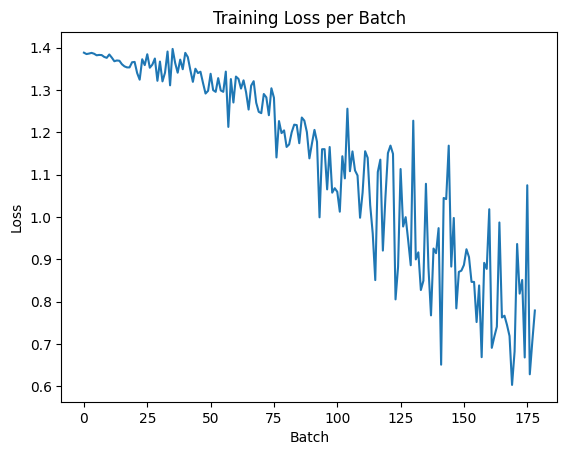

In [ ]:
batch_losses = []

for epoch in range(1):
    print(f'Training epoch {epoch}...')

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        batch_losses.append(loss.item())

        if i % 10 == 0:
            print(f'Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}')

plt.plot(batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()


In [18]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)

In [19]:
batch_losses = []

for epoch in range(3):
    print(f'Training epoch {epoch}...')

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        batch_losses.append(loss.item())

        if i % 10 == 0:
            print(f'Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}')

plt.plot(batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()


Training epoch 0...
Batch 1/90, Loss: 1.3803


KeyboardInterrupt: 

In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.0001)

Training epoch 0...
Batch 1/90, Loss: 1.3890
Batch 11/90, Loss: 1.1977
Batch 21/90, Loss: 1.1383
Batch 31/90, Loss: 0.9886
Batch 41/90, Loss: 0.9298
Batch 51/90, Loss: 0.8944
Batch 61/90, Loss: 0.7681
Batch 71/90, Loss: 0.7987
Batch 81/90, Loss: 0.7695
Epoch 1 Loss: 0.9153
Training epoch 1...
Batch 1/90, Loss: 0.6456
Batch 11/90, Loss: 0.6354
Batch 21/90, Loss: 0.6174
Batch 31/90, Loss: 0.4369
Batch 41/90, Loss: 0.4797
Batch 51/90, Loss: 0.5234
Batch 61/90, Loss: 0.6777
Batch 71/90, Loss: 0.5028
Batch 81/90, Loss: 0.4419
Epoch 2 Loss: 0.5371
Training epoch 2...
Batch 1/90, Loss: 0.4987
Batch 11/90, Loss: 0.3763
Batch 21/90, Loss: 0.3647
Batch 31/90, Loss: 0.3693
Batch 41/90, Loss: 0.5928
Batch 51/90, Loss: 0.3247
Batch 61/90, Loss: 0.5188
Batch 71/90, Loss: 0.3599
Batch 81/90, Loss: 0.4514
Epoch 3 Loss: 0.4412


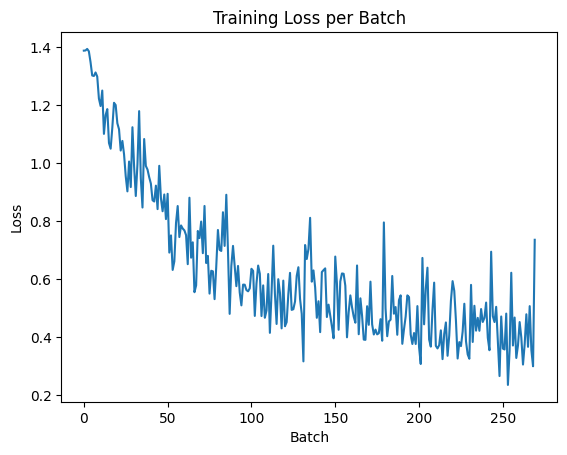

In [21]:
batch_losses = []

for epoch in range(3):
    print(f'Training epoch {epoch}...')

    running_loss = 0.0
    model.train()

    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        batch_losses.append(loss.item())

        if i % 10 == 0:
            print(f'Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}')

plt.plot(batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()


In [22]:
torch.save(model.state_dict(), 'trained_net.path')

In [23]:
model = BrainTumorCNN()
model.load_state_dict(torch.load('trained_net.path'))

<All keys matched successfully>

In [24]:
correct, total = 0, 0

model.eval()

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 78.18%


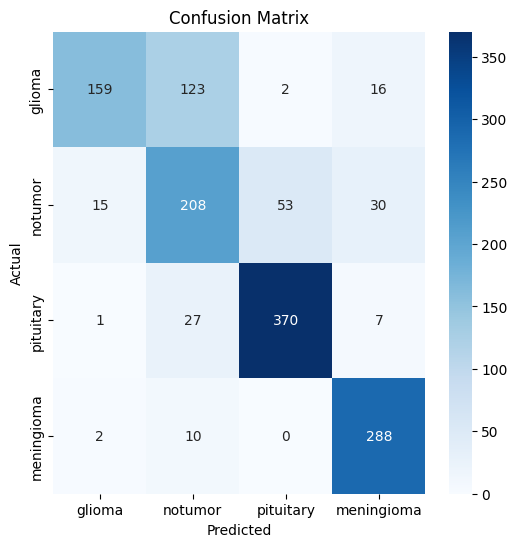

              precision    recall  f1-score   support

      glioma       0.90      0.53      0.67       300
     notumor       0.57      0.68      0.62       306
   pituitary       0.87      0.91      0.89       405
  meningioma       0.84      0.96      0.90       300

    accuracy                           0.78      1311
   macro avg       0.79      0.77      0.77      1311
weighted avg       0.80      0.78      0.78      1311



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['glioma', 'notumor', 'pituitary', 'meningioma']

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))
